In [389]:
H_LR1 = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
     }

H_LR2 = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
     }

H_LR4 = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
     }

In [115]:
import glob
import random
import matplotlib.pyplot as plt

In [116]:
from PIL import Image


In [117]:
import os
import psutil

In [118]:
!pip install tensorflow

Keyring is skipped due to an exception: 'keyring.backends'


In [119]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [120]:
data_dir = 'data/asl_dataset/asl_dataset/'

data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 2515 files belonging to 36 classes.


In [121]:
#Filtering out corrupted images

import os
num_skipped = 0
for folder_name in ("0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o"
                    ,"p","q","r","s","t","u","v","w","x","y","z"):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        #intenta abrir la imagen 
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        #si no hay problema abriendola la cierra
        finally:
            fobj.close()
        #si no puedo abrirla la borra
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 0 images


__________________Data augmentation________________

-------PARAMETROS QUE SE PODRIAN CAMBIAR--------

In [122]:
# Create an ImageDataGenerator and do Image Augmentation

#este es un generador de data augmentation
datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
        validation_split = 0.2)

Se redimensionan las imagenes de 400x400 a 228x228

In [123]:
#parametros de shape de la imagenes 
height = 228
width = 228
channels = 3

#tamano de batch para____ JAVI
batch_size = 32

#forma de la imagen
img_shape = (height, width, channels)
#tamano de imagen
img_size = (height, width)

#Coeficiente de learning rate para optimizador adam JAVI
LR = 1e-3

#con cada iteración se cambia el peso, hasta llegar al numero de epochs (iteraciones) deseadas hasta congelar el peso JAVI
epochs = 50

In [124]:
#esta funcion es muy util cuando no tenemos el data divido

#recuerda que data gen ya tiene el data aumentado
train_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 2012 images belonging to 36 classes.
Found 503 images belonging to 36 classes.


In [125]:
num_classes = len(data.class_names)
print('.... Number of Classes : {0} ....'.format(num_classes))

.... Number of Classes : 36 ....


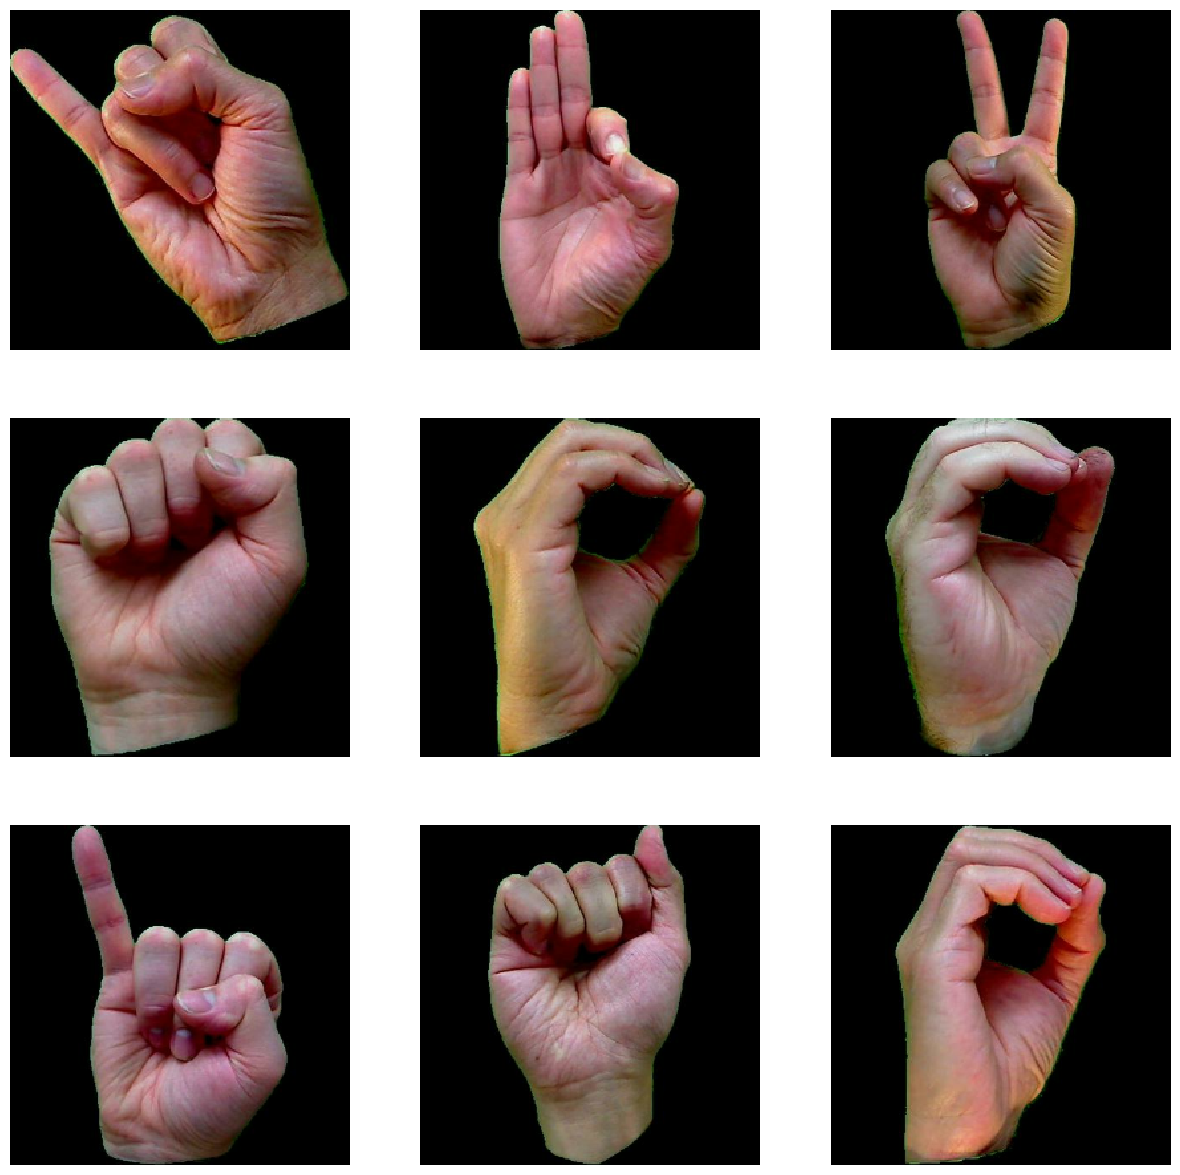

In [126]:
#Defing a function to see images
def show_img(data):
    plt.figure(figsize=(15,15))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset (el dataset de todas las imagenes no divididas)
show_img(data)

---------- Entrenamiento --------



Matematicas y mas parametros de adam:
    https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

In [127]:
# Steps per epoch 

#trainSteps = len(train_data) // batch_size
#valSteps = len(val_data) // batch_size

Instalaciones para entranmiento

In [128]:
#installs torch
!pip install torch==1.4.0+cpu torchvision>=0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Keyring is skipped due to an exception: 'keyring.backends'


In [129]:
#instala cv2
! pip uninstall opencv-python
! pip install opencv-python-headless

Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'


In [130]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import Dropout
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch.optim import Adam
from torch import nn

from sklearn.metrics import classification_report
from torch.utils.data import random_split

%matplotlib inline

! pip install -q imutils
from imutils import paths
import shutil
from urllib.request import urlopen
from PIL import Image

Keyring is skipped due to an exception: 'keyring.backends'


Ultima carga de archivos para dividr data en folders

In [131]:
import numpy as np 

#metodo para hacer copia de las imagenes de un folder en otra ruta 
#-> lo hacemos para dividr datos de entrenamiento y validacion
def copy_images(imagePaths, folder):
    
    # Crear un folder de destino
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    # recorrer las imagenes de la ruta que se de como parametro para irlas copiando
    for path in imagePaths:
        # Fetching name and label if the image and saving the files in training and validation folders
        #se guarda el nombre de la imagen hasta donde se encuentre un / del path
        imageName = path.split('/')[-1]
        #se guarda el nombre de la imagen hasta donde se encuentre un  segundo/ del path
        label = path.split('/')[-2]
        #se guarda folder con la etiqueta
        labelFolder = os.path.join(folder, label)
        
        #se crea folder con la etiqueta
        if not os.path.exists(labelFolder):
            os.makedirs(labelFolder)
            
        #construyes el path de destino para la nueva copia de la imagen
        destination = os.path.join(labelFolder, imageName)
        shutil.copy(path, destination)
        print("copiando")

In [132]:
#esto deberia ir arriba con estas librerias desde el inicio

PATH = 'data/asl_dataset/asl_dataset/'
TRAIN = "train"
VAL = "val"

#JAVI
BATCH_SIZE = 8
#JAVI
VAL_SPLIT  = 0.15

print(">>> Loading Image paths...\n")

imagePaths = list(paths.list_images(PATH))
np.random.shuffle(imagePaths)

# Generating train & val paths

valPathsLen = int(len(imagePaths) * VAL_SPLIT)
trainPathsLen = len(imagePaths) - valPathsLen

trainPaths = imagePaths[:trainPathsLen]
valPaths = imagePaths[trainPathsLen:]

# Copying the training and validation images to their respective directories using the function above

print(">>> Copying training and validation images...")
#copy_images(trainPaths, TRAIN)
#copy_images(valPaths, VAL)


>>> Loading Image paths...

>>> Copying training and validation images...


Clase para crear una red neuronal donde se tienen como parametros las capas de la NN y en la funcion forward de forward propagation se ocupan para hacer el entrenamiento del modelo con la NN

In [133]:
#dropout

class Net(Module):
    def __init__(self, numChannels, classes):
        super(Net, self).__init__()
        
        #se crean como atributos las funciones que se ocuparan para la NN pero que se esta importando
        #desde pytorch
        self.conv1 = Conv2d(in_channels=numChannels,
                            out_channels=20,
                            kernel_size=(5, 5))
        self.relu = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Define proportion or neurons to dropout
        self.do1 = nn.Dropout(0.2)  # 20% Probability

        self.conv2 = Conv2d(in_channels=20,
                            out_channels=50,
                            kernel_size=(5, 5))  

        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.fc1 = Linear(in_features=800, out_features=500)
        self.fc2 = Linear(in_features=500, out_features=classes)
        # Define proportion or neurons to dropout
        self.do2 = nn.Dropout(0.15)  # 20% Probability
        self.logSoftmax = LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        #a relu no le importan las dimensiones
        x = self.relu(x)
        x = self.maxpool1(x)
        
        # Apply dropout
        x = self.do1(x)
        
        x = self.conv2(x)
        
        
        
        x = self.relu(x)
        x = self.maxpool2(x)
        #attemp 2 ---
        #x = self.conv2(x)
        #x = self.relu(x)
        #x = self.conv2(x)
        #x = self.relu(x)
        #fin del attemp 2
        #RuntimeError: Given groups=1, weight of size 50 20 5 5, expected input[8, 50, 4, 4] to have 20 channels, but got 50 channels instead
        #x = self.conv3(x)
        #x = self.relu(x)
        #x = self.maxpool2(x)
    

        x = flatten(x, 1)
        
        #dense layer 1
        x = self.fc1(x)
        x = self.relu(x)
        
        #dense layer 2
        x = self.fc2(x)
        
        # Apply dropout
        x = self.do2(x)
        
        output = self.logSoftmax(x)

        return output

In [134]:
import time

In [135]:
print(train_data)

In [136]:
INPUT_HEIGHT = 28
INPUT_WIDTH  = 28
BATCH_SIZE = 8 # Se puede cambiar ??

# Initializing our transformations & augmentations

resize = transforms.Resize(size=(INPUT_HEIGHT, INPUT_WIDTH))
hFlip = transforms.RandomHorizontalFlip(p=0.25)
vFlip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)

# Initializing our training and validation set data augmentation pipeline

trainTransforms = transforms.Compose([resize, hFlip, vFlip, rotate, transforms.ToTensor()])
valTransforms = transforms.Compose([resize, transforms.ToTensor()])
# initialize the training and validation dataset

print(">>> Loading the training and validation dataset...\n")

trainDataset = ImageFolder(root = "train", transform = trainTransforms)
valDataset = ImageFolder(root = "val", transform = valTransforms)

print(">>> Training dataset contains {} samples...".format(len(trainDataset)))
print(">>> Validation dataset contains {} samples...".format(len(valDataset)))

# create training and validation set dataloaders

print(">>> Creating training and validation set dataloaders...")

trainDataLoader = DataLoader(trainDataset, batch_size = BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size = BATCH_SIZE)

# Steps per epoch 

trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE



>>> Loading the training and validation dataset...

>>> Training dataset contains 2138 samples...
>>> Validation dataset contains 377 samples...
>>> Creating training and validation set dataloaders...


In [137]:
print(trainDataLoader)

for (x, y) in trainDataLoader:
    example = x
    break
    

In [138]:
print(">>> Initializing the  model...")

#maquina de entranmiento de torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#instancia de la clase Net que es un modelo de deep learning de una red neuronal 
model = Net(numChannels=3, classes=len(trainDataLoader.dataset.classes)).to(device)


#optimizador al que se le pasan los parametros de la instancia del modelo y el learning rate 

opt = Adam(model.parameters(), lr=LR)
lossFn = nn.NLLLoss()

#scores de loss
H = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
     }

print(">>> Training the network...")


>>> Initializing the  model...
>>> Training the network...


In [139]:
y_true = []
y_pred = []
trainCorrect = 0

# inner psutil function
def process_memory():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss
 
# decorator function
def profile(func):
    def wrapper(*args, **kwargs):
 
        mem_before = process_memory()
        result = func(*args, **kwargs)
        mem_after = process_memory()
        print("{}:consumed memory: {:,}".format(
            func.__name__,
            mem_before, mem_after, mem_after - mem_before))
 
        return result
    return wrapper

 
#profile solo sirve con funciones
@profile

def train():
    
    for e in range(0, epochs):

        # Training
        model.train()

        totalTrainLoss = 0
        totalValLoss = 0

        trainCorrect = 0
        valCorrect = 0

        for (x, y) in trainDataLoader:

            (x, y) = (x.to(device), y.to(device))

            # Forward pass
            pred = model(x)
            
            # Compute loss
            loss = lossFn(pred, y)

            opt.zero_grad()
            
            # Backward pass
            loss.backward()
            
            opt.step()

            totalTrainLoss += loss
            trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Evaluation
        with torch.no_grad():

            model.eval()

            for (x, y) in valDataLoader:

                (x, y) = (x.to(device), y.to(device))
                y_true.extend(y.numpy())

                pred = model(x)
                totalValLoss += lossFn(pred, y)

                valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
                
                _, predicted = torch.max(pred, 1)
                y_pred.extend(predicted.cpu().numpy())

        # Calculating the average training and validation loss
        avgTrainLoss = totalTrainLoss / trainSteps
        avgValLoss = totalValLoss / valSteps

        # Calculating the training and validation accuracy
        trainCorrectAccuracy = trainCorrect / len(trainDataLoader.dataset) # like correcct/total
        valCorrectAccuracy = valCorrect / len(valDataLoader.dataset)

        # Updating training history
        H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
        H["train_acc"].append(trainCorrectAccuracy)
        H["val_loss"].append(avgValLoss.cpu().detach().numpy())
        H["val_acc"].append(valCorrectAccuracy)
        # instantiation of decorator function

        print("[INFO] EPOCH: {}/{}".format(e + 1, epochs))
        print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrectAccuracy))
        print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrectAccuracy))
        print("Total train correctos ",trainCorrect)
        print("Total val correctos ",valCorrect , "\n")
        
        


startTime = time.time()
train()


[INFO] EPOCH: 1/50
Train loss: 2.999420, Train accuracy: 0.1515
Val loss: 1.707051, Val accuracy: 0.5040

Total train correctos  324.0
Total val correctos  190.0 

[INFO] EPOCH: 2/50
Train loss: 1.981935, Train accuracy: 0.4065
Val loss: 1.105166, Val accuracy: 0.6021

Total train correctos  869.0
Total val correctos  227.0 

[INFO] EPOCH: 3/50
Train loss: 1.591792, Train accuracy: 0.5131
Val loss: 0.753452, Val accuracy: 0.7905

Total train correctos  1097.0
Total val correctos  298.0 

[INFO] EPOCH: 4/50
Train loss: 1.336422, Train accuracy: 0.5898
Val loss: 0.705004, Val accuracy: 0.7719

Total train correctos  1261.0
Total val correctos  291.0 

[INFO] EPOCH: 5/50
Train loss: 1.175919, Train accuracy: 0.6375
Val loss: 0.576073, Val accuracy: 0.8090

Total train correctos  1363.0
Total val correctos  305.0 

[INFO] EPOCH: 6/50
Train loss: 1.096982, Train accuracy: 0.6529
Val loss: 0.574363, Val accuracy: 0.8223

Total train correctos  1396.0
Total val correctos  310.0 

[INFO] EPOCH

In [140]:

endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))
print("Total time taken per sample: {:.10f}s".format((2138+377)/endTime))
print("Number of samples in the mini batch: {:.10f}s".format((2138+377)/endTime))
print("Time taken per batch: {:.10f}s".format(endTime/BATCH_SIZE))
#print("samples on each batch: {:.2f}s", BATCH_SIZE)
#BATCH_SIZ

Total time taken to train the model: 563.90s
Total time taken to train the model: 563.90s
Total time taken per sample: 0.0000015025s
Number of samples in the mini batch: 0.0000015025s
Time taken per batch: 209233083.7004473507s


In [141]:
#endTime = time.time()


In [142]:
import pandas as pd
H = pd.DataFrame(H)
H.head().style.applymap(lambda x : "background-color: #fadcb4")\
.set_table_styles([{'selector' : '', 'props' : [('border', '2px solid black')]}])

,train_loss,train_acc,val_loss,val_acc
0,2.9994204,0.151543,1.7070509,0.503979
1,1.9819351,0.406455,1.1051657,0.602122
2,1.5917915,0.513096,0.7534525,0.790451
3,1.3364218,0.589804,0.70500433,0.771883
4,1.1759189,0.637512,0.5760729,0.809019


In [143]:
import plotly.graph_objs as go

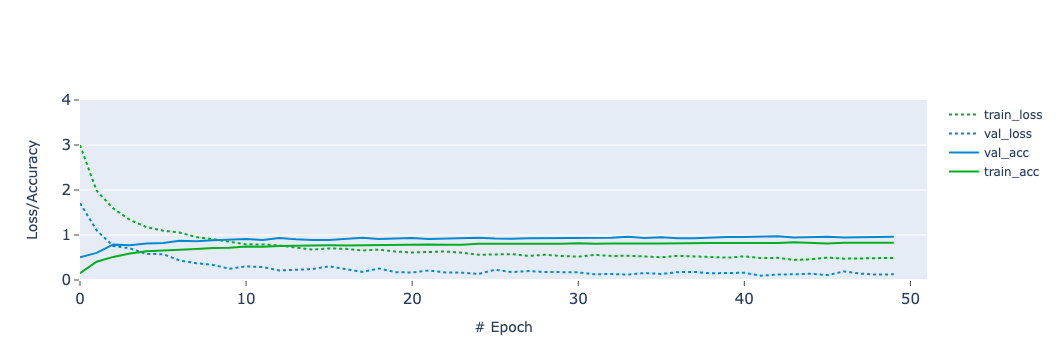

In [144]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = H.index,
                         y = H['train_loss'],
                         name = 'train_loss',
                         mode = 'lines',
                         line = dict(dash='dot'),
                         marker =  dict(color = '#05ad24')))

fig.add_trace(go.Scatter(y = H['val_loss'],
                         x = H.index,
                         name = 'val_loss',
                         mode = 'lines',
                         line = dict(dash='dot'),
                         marker =  dict(color = '#0688cf')))

fig.add_trace(go.Scatter(y = H['val_acc'],
                         x = H.index,
                         name = 'val_acc',
                         mode = 'lines',
                         marker =  dict(color = '#0688cf')))

fig.add_trace(go.Scatter(y = H['train_acc'],
                         x = H.index,
                         name = 'train_acc',
                         mode = 'lines',
                         marker =  dict(color = '#05ad24')))

fig.update_xaxes(title = '# Epoch',
        range = [0,51],
        tickfont = dict(size=15),
        tickmode = 'array',
        showline = False,
        showgrid = False,
        ticks = 'outside')

fig.update_yaxes(title = 'Loss/Accuracy',
        range = [0,4],
        tickfont = dict(size=15),
        tickmode = 'array',
        showline = True,
        showgrid = True,
        ticks = 'outside')


In [145]:
absolute_correct_train = trainCorrect*len(trainDataLoader.dataset)
print(absolute_correct_train)

0


In [146]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

In [147]:
class_names = ("0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o"
                    ,"p","q","r","s","t","u","v","w","x","y","z")
 
# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

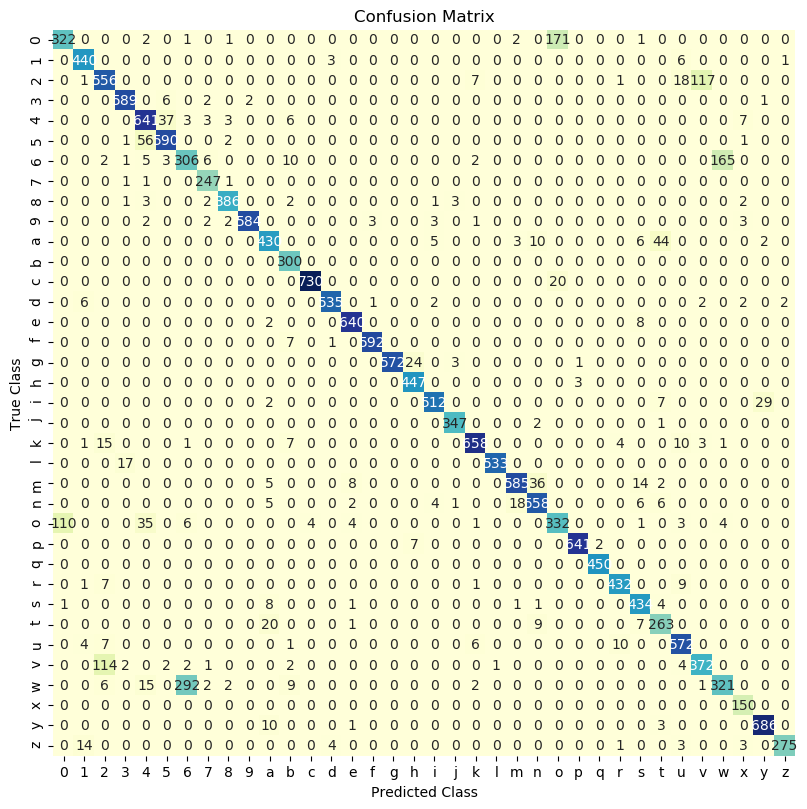

In [148]:
import seaborn as sns
plt.figure(figsize=(8, 8))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

In [149]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.64      0.69       500
           1       0.94      0.98      0.96       450
           2       0.79      0.79      0.79       700
           3       0.96      0.98      0.97       600
           4       0.84      0.92      0.88       700
           5       0.92      0.91      0.92       650
           6       0.50      0.61      0.55       500
           7       0.93      0.99      0.96       250
           8       0.97      0.96      0.97       400
           9       1.00      0.97      0.98       600
          10       0.89      0.86      0.88       500
          11       0.87      1.00      0.93       300
          12       0.99      0.97      0.98       750
          13       0.99      0.97      0.98       550
          14       0.97      0.98      0.98       650
          15       0.99      0.99      0.99       600
          16       1.00      0.95      0.98       600
          17       0.94    

In [150]:
#installs torch
!pip install torch==1.13+cpu torchvision>=0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Keyring is skipped due to an exception: 'keyring.backends'


In [151]:
# from torch.utils.mobile_optimizer import optimize_for_mobile
# from torch._C import _MobileOptimizerType as MobileOptimizerType

PATH = 'model_original.pt'
torch.save(model.state_dict(), PATH)

from torch.utils.mobile_optimizer import optimize_for_mobile

model_conv = model.to("cpu")

# example = torch.rand(1, 3, 228, 228)

# trace, optimize

traced_module = torch.jit.trace(model_conv, example)
optimized_model = optimize_for_mobile(traced_module)

PATH = 'model.pt'
optimized_model.save(PATH)

ImportError: cannot import name 'MobileOptimizerType' from 'torch._C' (/opt/conda/lib/python3.7/site-packages/torch/_C.cpython-37m-x86_64-linux-gnu.so)